# Problem and Data Description
In this project we are tasked with predicting metastatic cancer from images taken during pathology scans.  The goal is to identify cancerous tissue by analyzing small image patches taken from larger scans, a problem directly relevant to improving diagnostic accuracy in medical settings. This is a binary classification problem, where images are labeled as either containing cancerous tissue (label 1) or non-cancerous tissue (label 0).

The dataset consists of a substantial number of images: 220,025 images in the training set and approximately 57,458 images in the test set. Each image is a 96x96 pixel patch. The image data structure and large size emphasize the importance of a CNN architecture for capturing spatial patterns in the data, which is key to effectively identifying cancer cells.

https://www.kaggle.com/competitions/histopathologic-cancer-detection/data


In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import cv2
from glob import glob
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

In [8]:
#Import Data
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"natesmik","key":"ddf6da9d705a0dd3cb3d0bf9d7440360"}'}

In [9]:
os.makedirs('/root/.kaggle', exist_ok=True)
!mv kaggle.json /root/.kaggle/

In [10]:
!chmod 600 /root/.kaggle/kaggle.json

In [25]:
!kaggle competitions files -c histopathologic-cancer-detection

Next Page Token = CfDJ8GrUjsAKvhxNhvm67MmtKLkoHPfiVYa13tuBv3JANgsPUtJYpLY1zF6ngShAF7rSLo7dt04FigANFTcivw7mB1A
name                                               size  creationDate         
-------------------------------------------------  ----  -------------------  
test/000360e0d8358db520b5c7564ac70c5706a0beb0.tif  27KB  2019-12-12 00:22:25  
test/00118bec91b7fae175791896f7011ff506b3d7dd.tif  27KB  2019-12-12 00:22:25  
test/0000ec92553fda4ce39889f9226ace43cae3364e.tif  27KB  2019-12-12 00:22:25  
test/000253dfaa0be9d0d100283b22284ab2f6b643f6.tif  27KB  2019-12-12 00:22:25  
test/000698b7df308d75ec9559ef473a588c513a68aa.tif  27KB  2019-12-12 00:22:25  
test/000309e669fa3b18fb0ed6a253a2850cce751a95.tif  27KB  2019-12-12 00:22:25  
test/000997a6038fa7441aa0111ac456255060a354c4.tif  27KB  2019-12-12 00:22:25  
test/000e6341cf18365d35b40f4991002fec8834afc0.tif  27KB  2019-12-12 00:22:25  
test/0006e1af5670323331d09880924381d67d79eda0.tif  27KB  2019-12-12 00:22:25  
test/001161a2eca200f5

In [26]:
!kaggle competitions download -c histopathologic-cancer-detection

histopathologic-cancer-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [27]:
!unzip histopathologic-cancer-detection.zip -d histopathologic-cancer-detection

Archive:  histopathologic-cancer-detection.zip
replace histopathologic-cancer-detection/sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [28]:
data_path = "histopathologic-cancer-detection"
train_images_path = os.path.join(data_path, "train")
labels_path = os.path.join(data_path, "train_labels.csv")

# Load labels
labels_df = pd.read_csv(labels_path)
print(labels_df.head())

                                         id  label
0  f38a6374c348f90b587e046aac6079959adf3835      0
1  c18f2d887b7ae4f6742ee445113fa1aef383ed77      1
2  755db6279dae599ebb4d39a9123cce439965282d      0
3  bc3f0c64fb968ff4a8bd33af6971ecae77c75e08      0
4  068aba587a4950175d04c680d38943fd488d6a9d      0


# Exploratory Data Analysis

First, I'll look at the distribution of the classes to get a sense of how balanced the dataset is.

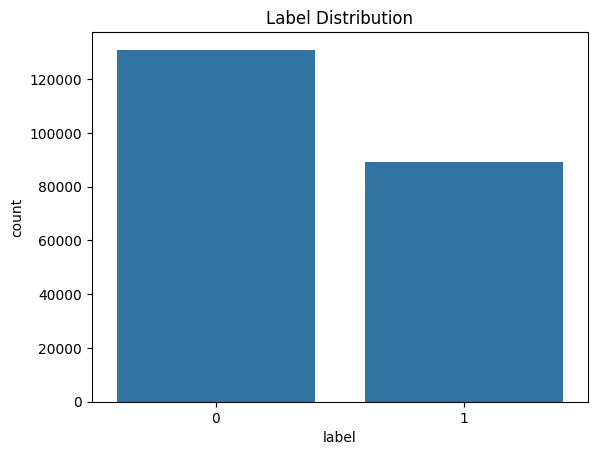

In [29]:
sns.countplot(x="label", data=labels_df)
plt.title("Label Distribution")
plt.show()

There is a slight imbalance in favor of the non-cancerous class, however it does not seem extreme and hopefully won't cause issues.  Now, let's look at some sample images from each class to get a visual sense of the data.

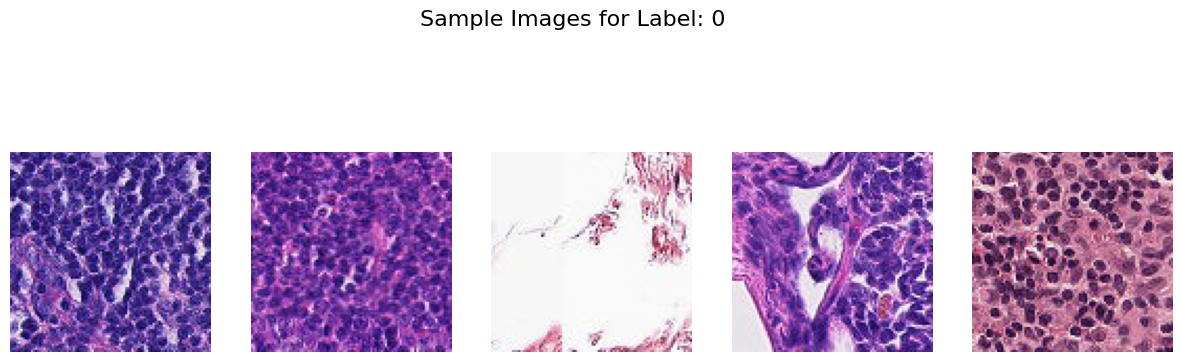

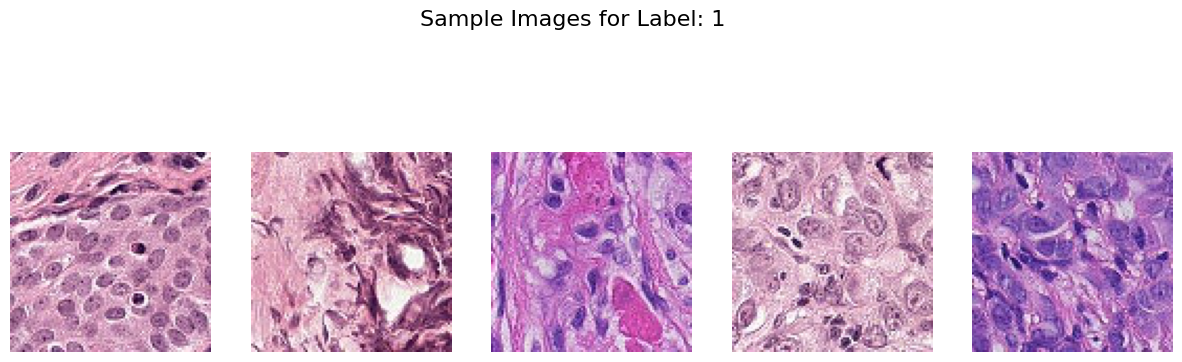

In [30]:
def display_class_samples(labels_df, images_path, label, num_samples=5):
    # Filter images by the specified label (0 or 1)
    class_samples = labels_df[labels_df["label"] == label].sample(num_samples)

    # Plot each sample
    fig, axs = plt.subplots(1, num_samples, figsize=(15, 5))
    fig.suptitle(f"Sample Images for Label: {label}", fontsize=16)
    for i, (idx, row) in enumerate(class_samples.iterrows()):
        image_path = os.path.join(images_path, f"{row['id']}.tif")
        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        axs[i].imshow(image)
        axs[i].axis("off")
    plt.show()

# Display samples from each class
display_class_samples(labels_df, train_images_path, label=0, num_samples=5)
display_class_samples(labels_df, train_images_path, label=1, num_samples=5)

# Model Architecture

To analyze the data, I will use CNN architecture to capture spatial features of the images.  Using Keras Tuner, I will try to optimize the model parameters such as the number of filters in each layer, kernel sizes, and dense layer units to achieve the best performance.  The architecture was designed to progressively capture spatial hierarchies through convolutional and pooling layers. Initial tuning results showed that a high filter count (96 filters) in the first convolutional layer improved feature extraction, suggesting that early layers should capture more complex features. Adding dropout with a 0.3 rate helped control overfitting, balancing model capacity and generalization.

In [31]:
# Convert labels to string format
labels_df["label"] = labels_df["label"].astype(str)
labels_df["id"] = labels_df["id"].apply(lambda x: f"{x}.tif")

from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Set up the data generator with augmentation options
datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,           # Normalize pixel values
    validation_split=0.2,           # Set validation split
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

# Prepare training and validation generators
train_generator = datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory=train_images_path,
    x_col="id",
    y_col="label",
    target_size=(24, 24),
    batch_size=16,
    class_mode="binary",
    subset="training",
    shuffle=True
)

val_generator = datagen.flow_from_dataframe(
    dataframe=labels_df,
    directory=train_images_path,
    x_col="id",
    y_col="label",
    target_size=(24, 24),
    batch_size=16,
    class_mode="binary",
    subset="validation"
)

Found 176020 validated image filenames belonging to 2 classes.
Found 44005 validated image filenames belonging to 2 classes.


In [33]:
!pip install -q -U keras-tuner
import keras_tuner as kt
from tensorflow.keras.callbacks import EarlyStopping


# Define the model-building function for Keras Tuner
def build_model(hp):
    model = Sequential()

    # Tune the number of filters and kernel size in the first Conv2D layer
    model.add(Conv2D(
        filters=hp.Int("conv_1_filter", min_value=32, max_value=128, step=32),
        kernel_size=hp.Choice("conv_1_kernel", values=[3, 5]),
        activation="relu",
        input_shape=(24, 24, 3)
    ))
    model.add(MaxPooling2D(2, 2))

    # Add a second Conv2D layer with tunable filters and kernel size
    model.add(Conv2D(
        filters=hp.Int("conv_2_filter", min_value=64, max_value=256, step=64),
        kernel_size=hp.Choice("conv_2_kernel", values=[3, 5]),
        activation="relu"
    ))
    model.add(MaxPooling2D(2, 2))

    model.add(Flatten())

    # Tune the number of units in the Dense layer
    model.add(Dense(
        units=hp.Int("dense_units", min_value=32, max_value=256, step=32),
        activation="relu"
    ))

    # Tune the dropout rate
    model.add(Dropout(hp.Float("dropout_rate", min_value=0.3, max_value=0.7, step=0.1)))

    model.add(Dense(1, activation="sigmoid"))

    # Compile the model with binary crossentropy loss for binary classification
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    return model

# Initialize the tuner
tuner = kt.RandomSearch(
    build_model,
    objective="val_accuracy",
    max_trials=3,
    executions_per_trial=1,
    directory="hyperparameter_tuning",
    project_name="histopathologic_cancer_detection"
)

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

# Run the tuner search
tuner.search(
    train_generator,
    epochs=5,
    validation_data=val_generator,
    callbacks=[early_stopping]
)

# Get the best model found by Keras Tuner
best_model = tuner.get_best_models(num_models=1)[0]

# Print the summary of the best model
best_model.summary()

Trial 3 Complete [01h 04m 49s]
val_accuracy: 0.8069083094596863

Best val_accuracy So Far: 0.8069083094596863
Total elapsed time: 03h 34m 59s


/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:576: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 22, 22, 96)          │           2,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 11, 11, 96)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 9, 9, 64)            │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 4, 4, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 32)                  │          32,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 90,881 (355.00 KB)

 Trainable params: 90,881 (355.00 KB)

 Non-trainable params: 0 (0.00 B)

In [34]:
# Display best hyperparameters
best_hyperparameters = tuner.get_best_hyperparameters(1)[0]
print("Best Hyperparameters:")
print(best_hyperparameters.values)

Best Hyperparameters:
{'conv_1_filter': 96, 'conv_1_kernel': 3, 'conv_2_filter': 64, 'conv_2_kernel': 3, 'dense_units': 32, 'dropout_rate': 0.3}


The hyperparameter tuning took a couple hours to complete.  Using Keras Tuner, the following hyperparameters were identified as optimal:  
	•	conv_1_filter: 96 filters  
	•	conv_1_kernel: 3x3 kernel size.       
	•	conv_2_filter: 64 filters   
	•	conv_2_kernel: 3x3 kernel size   
	•	dense_units: 32   
	•	dropout_rate: 0.3   

These hyperparameters reflect a balance between model complexity and training efficiency.  A higher filter count in the first layer allows the model to capture complex patterns early in the network.  The 3x3 kernel size in both convolutional layers was consistently effective, as it captures essential spatial information while keeping computational requirements manageable.  The smaller dense layer with 32 units, coupled with a 0.3 dropout rate, provided enough capacity to learn meaningful representations while avoiding overfitting.

# Results and Analysis

In [35]:
test_images_path = os.path.join(data_path, "test")
test_df = pd.DataFrame({"id": [img[:-4] for img in os.listdir(test_images_path)]})

# Apply ".tif" extension to match actual filenames in the directory
test_df["id"] = test_df["id"].apply(lambda x: f"{x}.tif")

# Create a test data generator
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)  # Normalize pixel values

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory=test_images_path,
    x_col="id",
    y_col=None,
    target_size=(24, 24),
    batch_size=32,
    class_mode=None,
    shuffle=False
)

Found 57458 validated image filenames.


In [36]:
# Predict using the best model from tuning
predictions = best_model.predict(test_generator)
predictions = (predictions > 0.5).astype(int).flatten()

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 123s 68ms/step


Create Kaggle Submission

In [39]:
# Remove ".tif" from test IDs for the Kaggle submission format
test_image_ids = [img_id[:-4] for img_id in test_generator.filenames]

# Create a DataFrame for the submission
submission_df = pd.DataFrame({
    "id": test_image_ids,
    "label": predictions
})

# Save to CSV file
submission_df.to_csv("submission.csv", index=False)
from google.colab import files
files.download("submission.csv")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Conclusions
Despite extensive tuning the model only achieved 51.5% accuracy on the test set, suggesting basic CNN may have been too limited for the task.  In future iterations, I would explore higher image resolutions to retain more detail. Implementing more advanced data augmentation techniques, like contrast adjustment, could also improve the model’s ability to generalize to unseen data.